<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/Image_high_resolution_reconstruction_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
from keras.layers import Layer # Import the Layer class for custom layers
from keras.utils import register_keras_serializable # Import the decorator for registering custom objects
from keras.models import load_model # Import the load_model function

import os
import math
import numpy as np

from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
root_dir = "/content/drive/MyDrive/Datasets/BSDS500/images/"


#Create training and validation datasets via image_dataset_from_directory.

In [4]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    f"{root_dir}/training",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,  # No labels expected
)

valid_ds = image_dataset_from_directory(
    f"{root_dir}/validation",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,  # No labels expected
)

Found 200 files.
Using 160 files for training.
Found 100 files.
Using 20 files for validation.


In [5]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

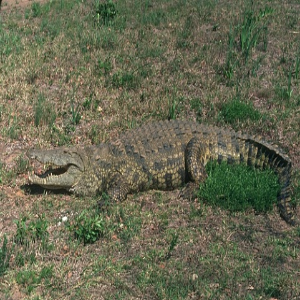

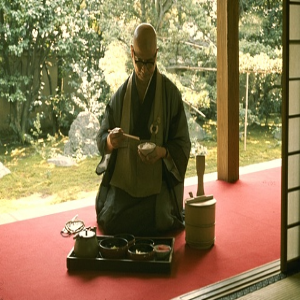

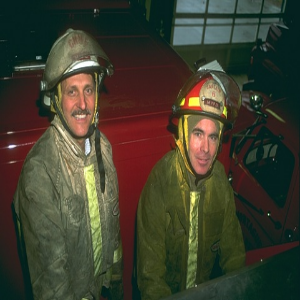

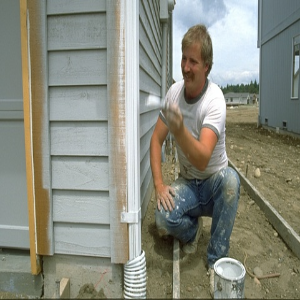

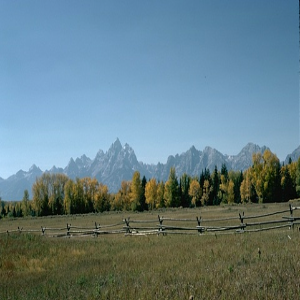

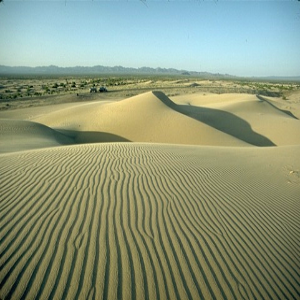

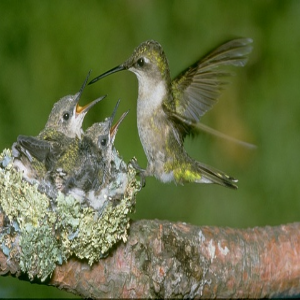

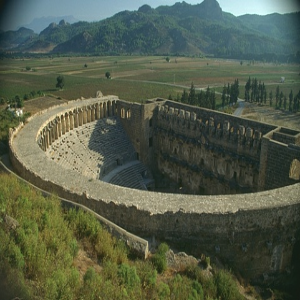

In [6]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

#Prepare a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [7]:
test_path= os.path.join(root_dir, "test")


test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

#Crop and resize images

In [8]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

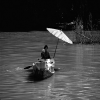

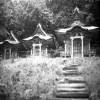

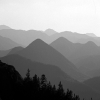

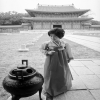

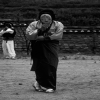

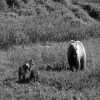

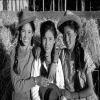

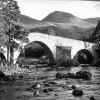

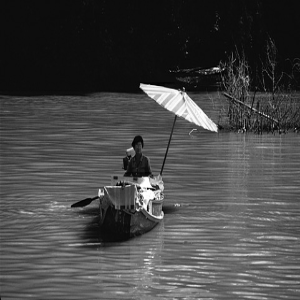

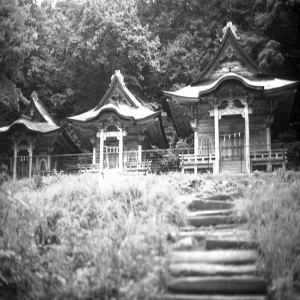

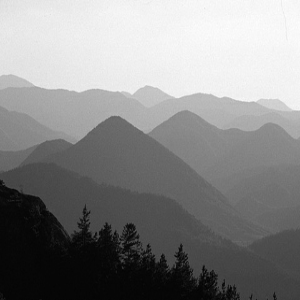

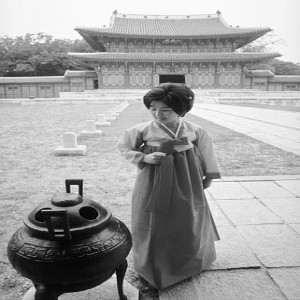

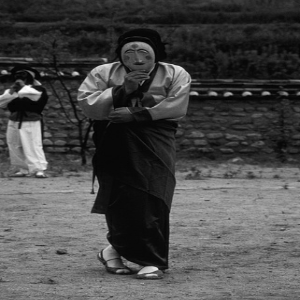

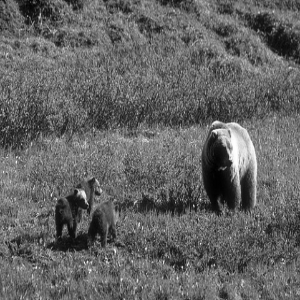

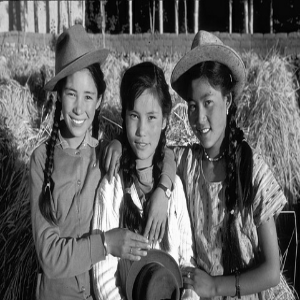

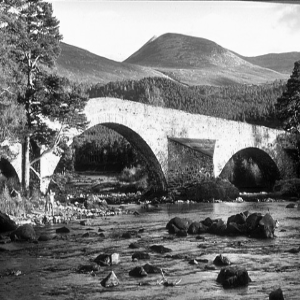

In [9]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

#Build the model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": None,  # We apply activation separately after BatchNorm
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }

    inputs = keras.Input(shape=(None, None, channels))

    # First convolutional layer
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolutional layer
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Third convolutional layer
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Residual Connection
    residual = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(inputs)
    residual = layers.BatchNormalization()(residual)

    # Add residual connection
    x = layers.Add()([x, residual])

    # Final convolution to match the upscale factor
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)

    # Pixel shuffling for upscaling
    outputs = layers.Lambda(lambda x: tf.nn.depth_to_space(x, upscale_factor))(x)

    return keras.Model(inputs, outputs)
